This notebook is submitted by the following group members of PGDBA Batch

1.   24BM6JP05 - Aniket Thakur
2.   24BM6JP33 - Mohsin Parmar
3.   24BM6JP38 - Pabbaraju Harsha
4.   24BM6JP44 - Rahul Verma
5.   24BM6JP46 - Sachin Goyal

## 1. Installing Library and Importing Data
To begin, we install necessary libraries and fetch the Heart Disease dataset from the UCI Machine Learning Repository.

In [ ]:
!pip install ucimlrepo
!pip install pgmpy
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


We then import necessary libraries

In [ ]:
# Data Handling & Analysis
import pandas as pd    # For loading and manipulating structured data (DataFrames)
import numpy as np     # For numerical operations and handling arrays

# Data Visualization
import matplotlib.pyplot as plt  # For plotting graphs & visualizing results
import seaborn as sns  # Advanced visualization (heatmaps, histograms, KDE plots)

# Ignore Warnings (Useful when working with large datasets)
import warnings
warnings.filterwarnings("ignore")

# UCI Repository Fetching
from ucimlrepo import fetch_ucirepo  # Directly fetch datasets from UCI ML Repository

# Machine Learning Preprocessing & Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Train-test splitting & model selection
from sklearn.preprocessing import KBinsDiscretizer  # Discretization of numerical features
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB  # Different Naïve Bayes classifiers

# Evaluation Metrics
from sklearn.metrics import (
    fbeta_score,      # F2-score (weighted recall-based evaluation)
    accuracy_score,   # Overall accuracy of predictions
    classification_report,  # Precision, Recall, F1-score breakdown
    confusion_matrix,  # For visualizing misclassifications
    make_scorer  # Custom scorer for cross-validation
)

# Bayesian Network Modeling (Advanced)
from sklearn.cluster import KMeans  # Clustering for potential feature engineering
from pgmpy.models import BayesianNetwork  # Bayesian Network Model
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator  # Learn Bayesian structure & parameters
from pgmpy.inference import VariableElimination  # Perform inference in Bayesian Networks
import networkx as nx  # Graph visualization for Bayesian Network

We use UCI library to fetch heart disease dataset and then inspect the dataset, statistical properties and missing values across features

In [ ]:
# Fetch dataset from UCI repository
heart_disease = fetch_ucirepo(id=45)

# Extract features and target
X = heart_disease.data.features
y = heart_disease.data.targets

In [ ]:
# Display dataset info
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [ ]:
# Check for missing values
print('\nMissing values for each column\n',X.isna().sum())


Missing values for each column
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [ ]:
X[X.isna().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


## 2. Data Pre-processing

As the missing values are less than 5% in respective columns, we are imputing the categorical data with mode

In [ ]:
# Impute missing values for categorical columns using mode (most frequent value)
X.loc[:, "ca"] = X["ca"].fillna(X["ca"].mode()[0])
X.loc[:, "thal"] = X["thal"].fillna(X["thal"].mode()[0])

We then verify to ensure that all missing values are taken care of

In [ ]:
# Verify that missing values are handled
print('\nMissing values for each column\n',X.isna().sum())


Missing values for each column
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


## 3. Exploratory Data Analysis
To understand our dataset, we visualize the distributions of categorical and numerical features.

### Bar plot for Categorical Features

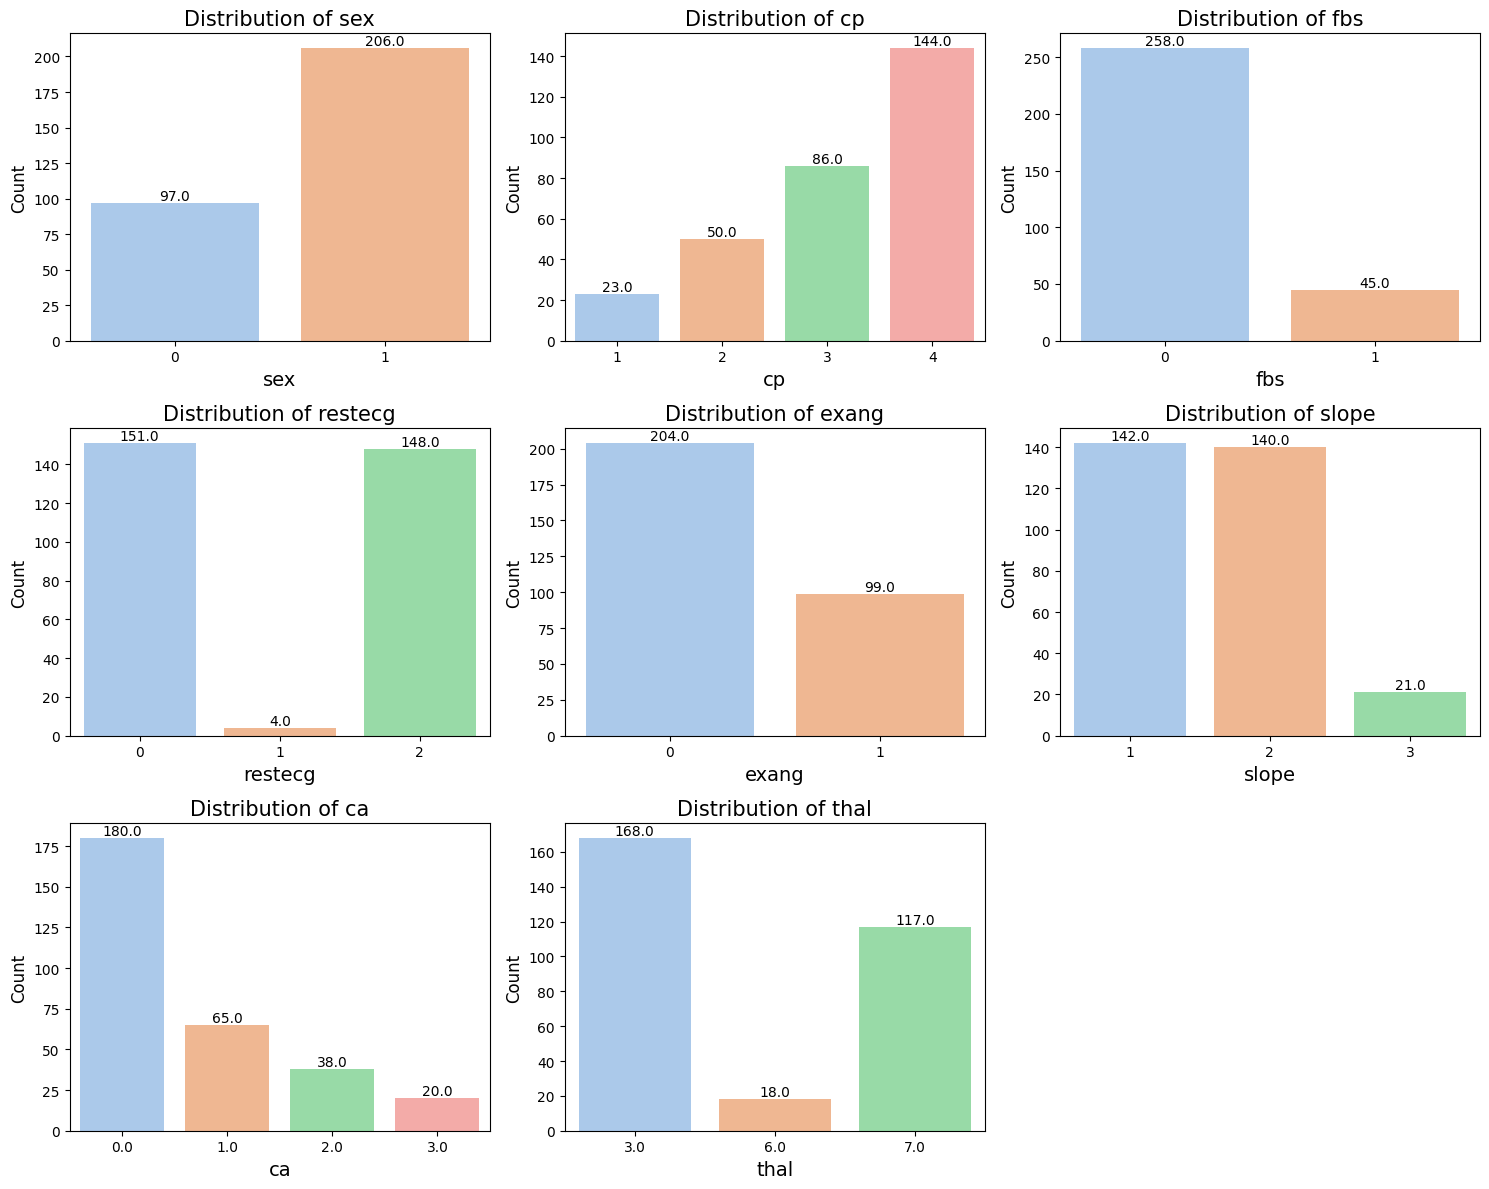

In [ ]:
# Set figure size
plt.figure(figsize=(15, 12))

# Feature list
categorical_features_list = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Define color palette
palette = sns.color_palette("pastel")

# Loop through each feature
for i, f in enumerate(categorical_features_list):
    plt.subplot(3, 3, i+1)  # 3x3 layout
    ax = sns.countplot(data=X, x=f, palette=palette)  # Countplot with pastel colors
    plt.title(f"Distribution of {f}", fontsize=15)  # Title
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(f, fontsize=14)
    plt.xticks(fontsize=10)

    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Histogram for Numerical Features

The histograms and probability density plots for selected columns ('age', 'chol', 'trestbps', 'thalach', 'oldpeak', 'target') using seaborn and matplotlib. It visualizes the data distribution and underlying probability for these features.

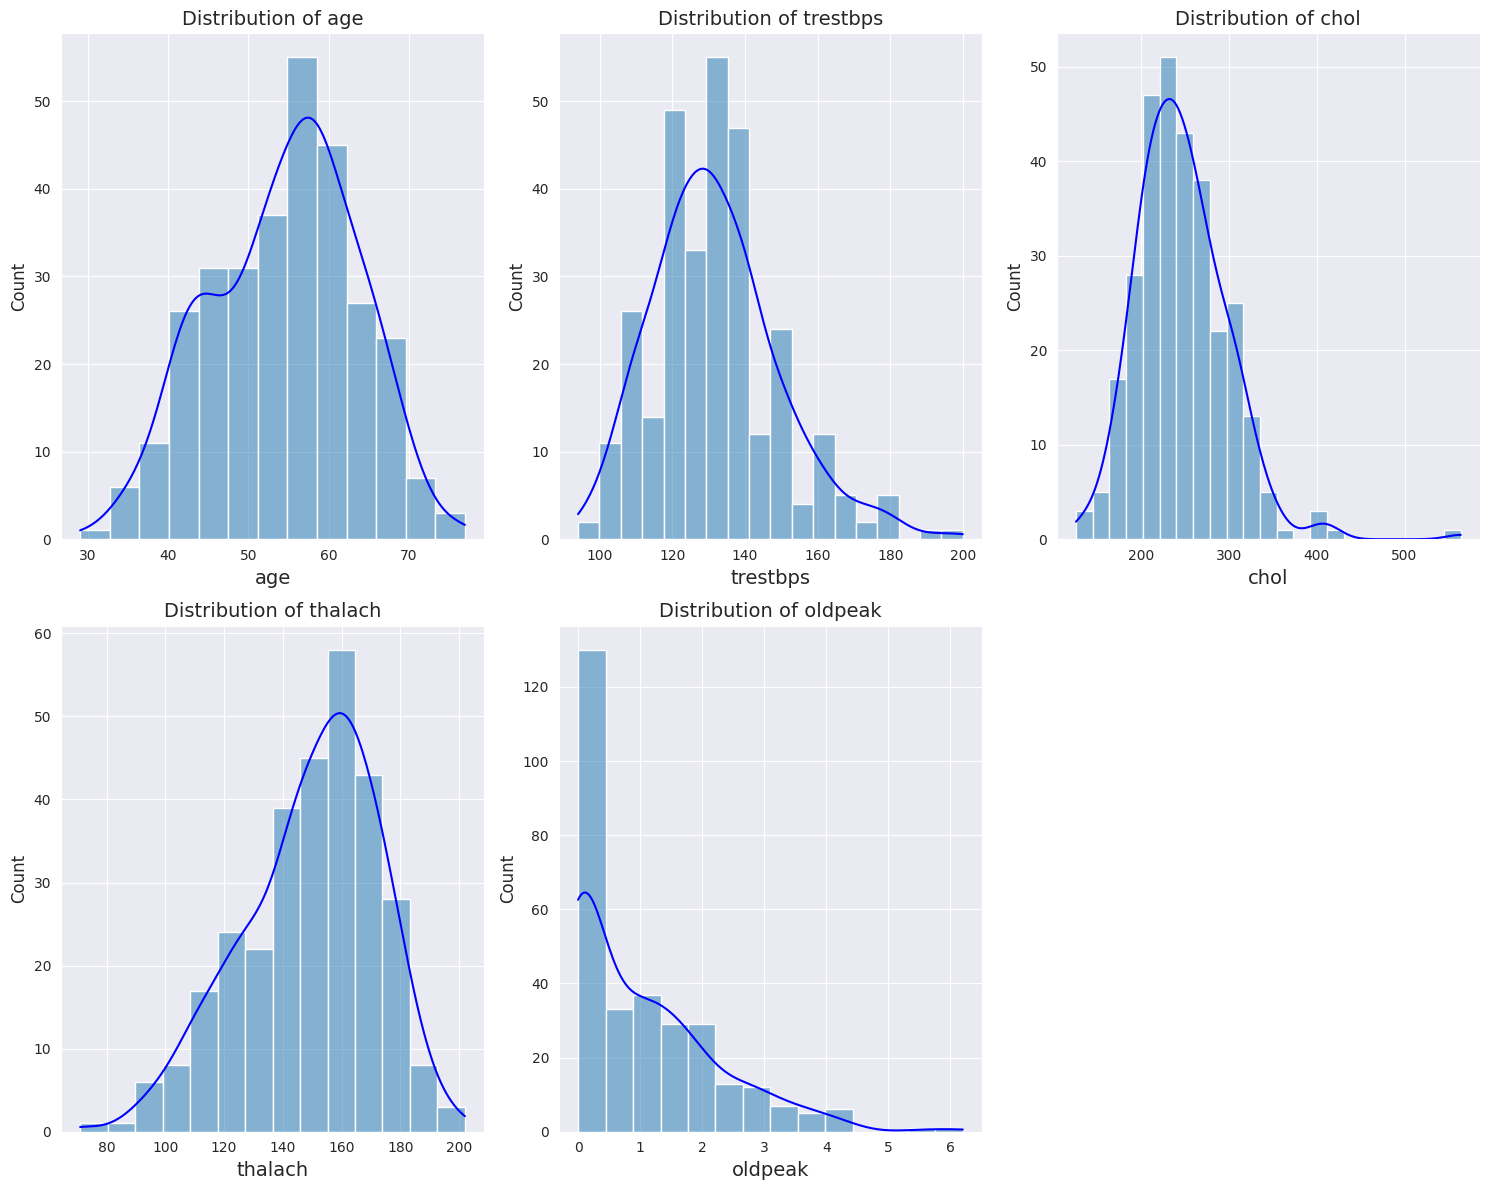

In [ ]:
# Set figure size
plt.figure(figsize=(15, 12))
sns.set_style("darkgrid")

# Feature list
numerical_features_list = ['age','trestbps', 'chol','thalach','oldpeak']

# Loop through each feature
for i, f in enumerate(numerical_features_list):
    plt.subplot(2, 3, i+1)  # 3x3 layout
    ax = sns.histplot(data=X, x=f,kde=True)  # Countplot with pastel colors
    ax.lines[0].set_color("blue")
    plt.title(f"Distribution of {f}", fontsize=14)  # Title
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(f, fontsize=14)
    plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()


### Feature Correlation Matrix

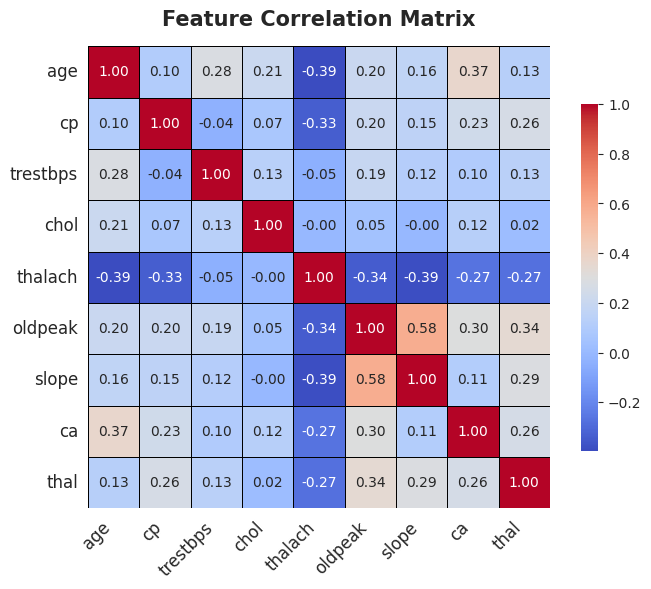

In [ ]:
# Compute correlation matrix
cor_features = ['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca', 'thal']
cor_matrix = X[cor_features].corr()

# Set figure size
plt.figure(figsize=(8, 6))

# Create heatmap with better styling
sns.heatmap(
    cor_matrix,
    annot=True,
    cmap="coolwarm",  # Diverging colormap for better contrast
    fmt=".2f",  # Show only 2 decimal places
    linewidths=0.5,  # Thin lines between cells
    linecolor="black",  # Border color
    square=True,  # Keep cells square
    cbar_kws={"shrink": 0.75},  # Adjust colorbar size
)

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal
plt.title("Feature Correlation Matrix", fontsize=15, fontweight="bold", pad=15)  # Add title

plt.show()

**Why Not use K-Means for getting bins**
This code is Just to show that why making bins using k-means is not a great idea

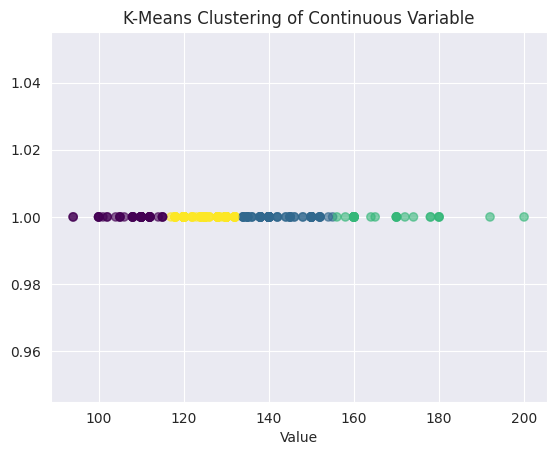

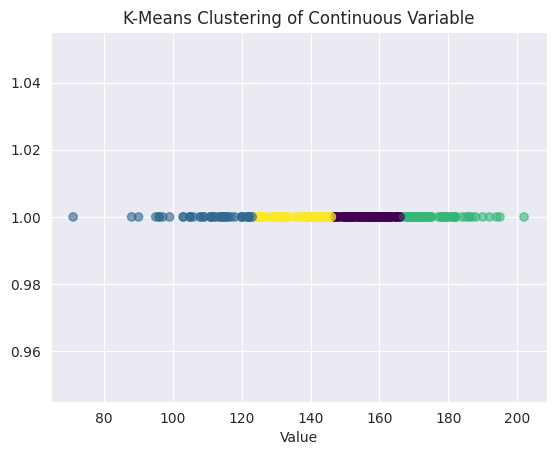

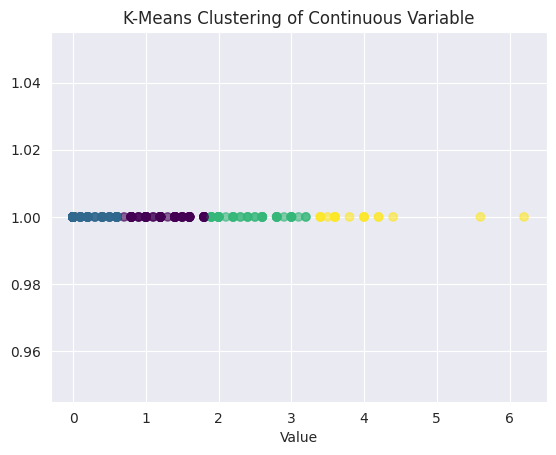

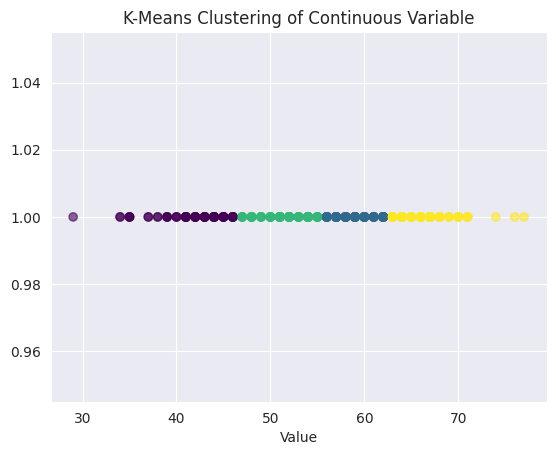

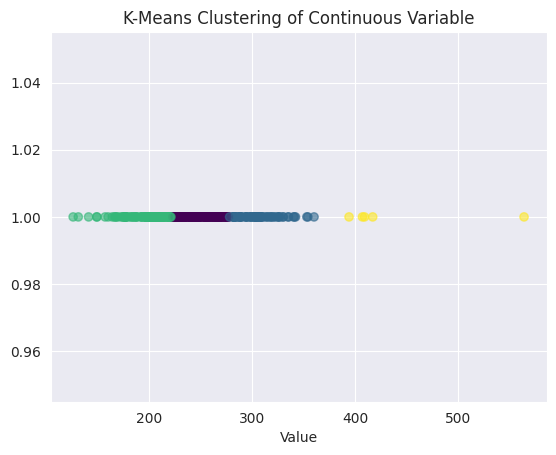

In [ ]:
for i in ['trestbps','thalach','oldpeak','age','chol']:
  data = X[i]
# Reshape for KMeans (expects 2D data)
  data_reshaped = np.array(data).reshape(-1, 1)

  # Try clustering into 3 groups (you can change this)
  kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
  labels = kmeans.fit_predict(data_reshaped)

  # Plot results
  plt.scatter(data, [1] * len(data), c=labels, cmap='viridis', alpha=0.6)
  plt.xlabel('Value')
  plt.title('K-Means Clustering of Continuous Variable')
  plt.show()

K-means is bad for discretizing in Naïve Bayes because it assigns clusters based on proximity rather than true distribution. This causes extreme small and large values to be grouped with dense regions, leading to incorrect probability assignments. It does not consider the actual shape of the data distribution, making it unsuitable for probability estimation.

## 3. Fitting Naive Bayes Model from Sci-kit Learn module

### Applying Gaussian Naive Bayes Model

Since Our dataset has continuous numerical features as well, We will apply Gaussian naive bayes model first. Due to the presence of class imbalance in our dataset, we have stratified our data into classes before splitting into train and test for each of the class strata

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=20,stratify=y)

print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: (242, 13)
Shape of X_test: (61, 13)
Shape of y_train: (242, 1)
Shape of y_test: (61, 1)


In [ ]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train,y_train)

f2_scorer = make_scorer(fbeta_score,beta=2,average='weighted')

f2_score_val = cross_val_score(GaussianNB(),X_train,y_train,cv=5,scoring=f2_scorer)
print(f2_score_val)
print(f"Average f2 score in cross validation: {f2_score_val.mean():.4f}")

[0.54210274 0.61576938 0.46715856 0.51465469 0.54174608]
Average f2 score in cross validation: 0.5363


In [ ]:
y_predict= gnb_clf.predict(X_test)

f2_score = fbeta_score(y_test, y_predict, beta=2, average='weighted')
print(f"F2-Score: {f2_score:.4f}")
print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_predict):.4f}")
print(f"Classification Report:\n {classification_report(y_test,y_predict)}")

F2-Score: 0.6128
Test Data Accuracy Score: 0.6066
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.31      0.36      0.33        11
           2       0.38      0.43      0.40         7
           3       0.67      0.29      0.40         7
           4       0.00      0.00      0.00         3

    accuracy                           0.61        61
   macro avg       0.45      0.39      0.40        61
weighted avg       0.66      0.61      0.63        61



Medical datasets, where positive cases are rare, are an example of highly imbalanced datatset where recall (False Negative) becomes more important than precision. Hence, We will put more focus on the metric F2-score(weighted) and use this metric to compare with other models as well.

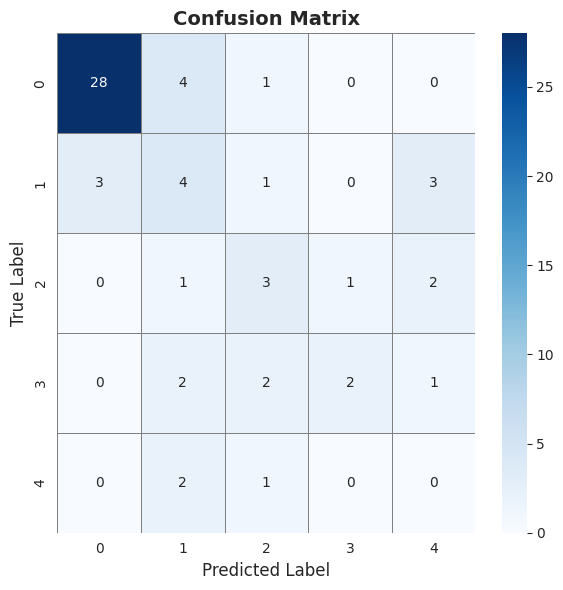

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.6, linecolor="grey")

# Improve readability
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Our model faced several challenges that impacted its performance. Gaussian Naïve Bayes (GaussianNB) achieved an accuracy of 60.66%, indicating that while it correctly classified a majority of cases, it struggled with recall on minority classes. The high precision (90%) for Class 0 suggests that the model made very few false positive predictions for patients with no heart disease. However, precision dropped significantly for Classes 3 and 4, meaning the model failed to correctly identify severe heart disease cases. This imbalance in performance highlights the limitations of GaussianNB when applied to datasets with highly skewed class distributions.

One of the key issues was the assumption that features follow a Gaussian (normal) distribution, which may not hold for all variables. Additionally, the model tended to favor the majority class, leading to a high false negative rate for minority classes. As a result, while the model performed well for the most common cases, it lacked sensitivity in detecting more severe heart disease conditions. Further improvements could be made by adjusting class priors or incorporating resampling techniques to balance the dataset.

### Fitting Multinomial NB Model and using GridSearch to find optimal value of smoothing parameter

Discretization of the numerical features:
Now lets see how well Multinomial and Categorical Naive Bayes model performs, but before fitting these models, we will have to convert the continuous features in our dataset into categorical fetaures. For this, we will use standard library "KBinDiscretizer" from Scikit learn.

In [ ]:
# Discretizing the Numerical Varaibels
discretizer = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')

numerical_features_list = ['age','trestbps', 'chol','thalach','oldpeak']

X[numerical_features_list] = (discretizer.fit_transform(X[numerical_features_list])).astype(int)

Now, when we have converted the features, we will apply Multinomial naive model first.
Also, we will use GridSearchCV to tune the Hyperparameter alpha (smoothing constant).

In [ ]:
param_grid = {"alpha":range(1,8,1)}
f2_scorer = make_scorer(fbeta_score,beta=2,average="weighted")

clf_model = GridSearchCV(MultinomialNB(),param_grid,cv=5,scoring=f2_scorer)
clf_model.fit(X_train,y_train)

df=pd.DataFrame(clf_model.cv_results_)
print(df[['params', 'mean_test_score']])

         params  mean_test_score
0  {'alpha': 1}         0.524786
1  {'alpha': 2}         0.527822
2  {'alpha': 3}         0.530274
3  {'alpha': 4}         0.521156
4  {'alpha': 5}         0.521239
5  {'alpha': 6}         0.520632
6  {'alpha': 7}         0.516863


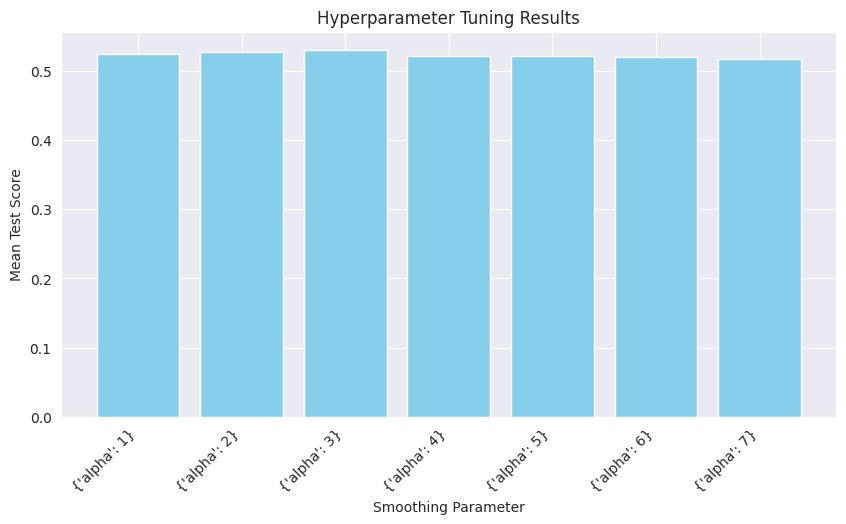

In [ ]:
# Ensure 'params' are strings if they contain dictionaries
df["params"] = df["params"].astype(str)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(df["params"], df["mean_test_score"], color='skyblue')

# Labels and title
plt.xlabel("Smoothing Parameter")
plt.ylabel("Mean Test Score")
plt.title("Hyperparameter Tuning Results")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
# Show the plot
plt.show()

In [ ]:
clf_model.best_score_

0.5302738608567201

In [ ]:
clf_model.best_params_

{'alpha': 3}

As we can see from the above plot, we get the best cross validation score at alpha=5. So, we will use this value for fitting the Multinomial Naive Bayes model.

In [ ]:
MNB_model = MultinomialNB(**clf_model.best_params_)
MNB_model.fit(X_train,y_train)

y_predict= MNB_model.predict(X_test)

f2_score = fbeta_score(y_test, y_predict, beta=2, average='weighted')
print(f"F2-Score: {f2_score:.4f}")
print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_predict):.4f}")
print(f"Classification Report:\n {classification_report(y_test,y_predict)}")

F2-Score: 0.5723
Test Data Accuracy Score: 0.5738
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        33
           1       0.42      0.45      0.43        11
           2       0.14      0.14      0.14         7
           3       0.14      0.14      0.14         7
           4       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg       0.31      0.32      0.31        61
weighted avg       0.57      0.57      0.57        61



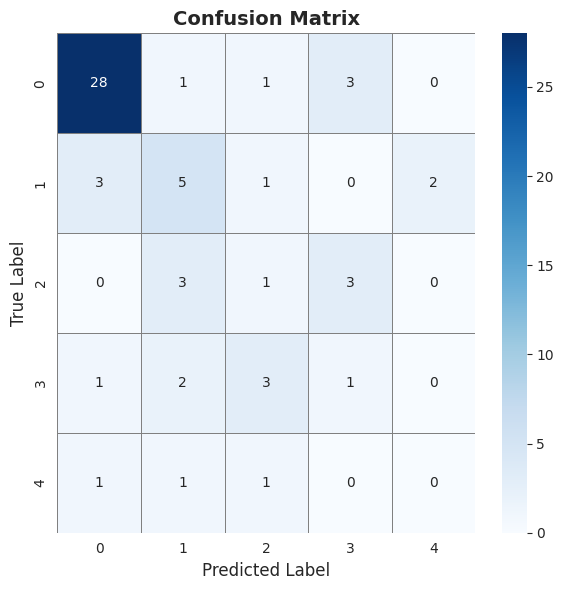

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.6, linecolor="grey")

# Improve readability
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Multinomial Naïve Bayes performed slightly worse than GaussianNB, with an accuracy of 57.38% and an F2-score of 0.5723. The model handled categorical features well, but the overall performance was weakened by the reliance on discretized numerical variables. While precision for Class 0 remained high (85%), the model failed to differentiate between the more severe classes, with Class 3 and Class 4 having almost no recall.

One potential reason for this drop in performance is the loss of granularity introduced by feature binning. Discretization helped Naïve Bayes estimate probabilities better, but it may have caused loss of critical information in continuous variables like chol (cholesterol levels) and thalach (maximum heart rate). This could explain the lower recall scores, as some bins may have contained very few samples, making probability estimates unreliable.

Additionally, Naïve Bayes assumes that all features contribute equally to the final classification, but in medical data, certain features (like ca and thal) may have a stronger impact on heart disease prediction than others. This assumption may have led to misclassifications, particularly for borderline cases.

### Fitting Categorical NB Model

Now,lets fit the Categorical Naive Bayes Model and see the model performance. And again, we will use GridSearchCV to tune the hyperparameter alpha

In [ ]:
param_grid = {"alpha":range(0,8,1)}
f2_scorer = make_scorer(fbeta_score,beta=2,average="weighted")

clf_model = GridSearchCV(CategoricalNB(),param_grid,cv=5,scoring=f2_scorer)
clf_model.fit(X_train,y_train)

df=pd.DataFrame(clf_model.cv_results_)
df['mean_score'] = df[['split0_test_score','split1_test_score','split2_test_score','split3_test_score']].mean(axis=1)
df[["params","mean_score"]]

,params,mean_score
0,{'alpha': 0},0.574237
1,{'alpha': 1},0.594355
2,{'alpha': 2},0.591184
3,{'alpha': 3},0.570562
4,{'alpha': 4},0.556081
5,{'alpha': 5},0.560428
6,{'alpha': 6},0.564265
7,{'alpha': 7},0.556807


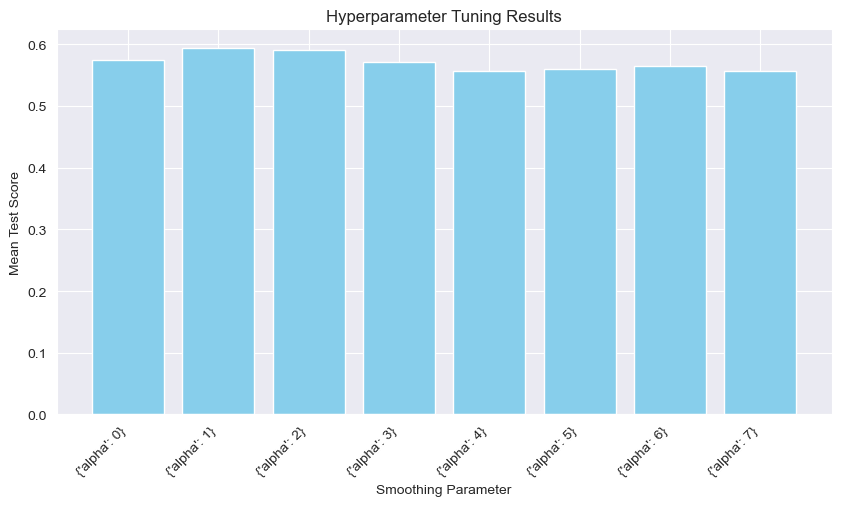

In [ ]:
# Ensure 'params' are strings if they contain dictionaries
df["params"] = df["params"].astype(str)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(df["params"], df["mean_score"], color='skyblue')

# Labels and title
plt.xlabel("Smoothing Parameter")
plt.ylabel("Mean Test Score")
plt.title("Hyperparameter Tuning Results")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
# Show the plot
plt.show()

As we can see from the above plot, we get the best cross validation score at alpha=1. So, we will use this value for fitting the Categorical Naive Bayes model.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=20,stratify=y)

CNB_model = CategoricalNB(alpha=1)
CNB_model.fit(X_train,y_train)


y_predict= CNB_model.predict(X_test)

f2_score = fbeta_score(y_test, y_predict, beta=2, average='weighted')
print(f"F2-Score: {f2_score:.4f}")
print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_predict):.4f}")
print(f"Classification Report:\n {classification_report(y_test,y_predict)}")

F2-Score: 0.5170
Test Data Accuracy Score: 0.5246
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84        33
           1       0.12      0.09      0.11        11
           2       0.14      0.14      0.14         7
           3       0.00      0.00      0.00         7
           4       0.33      0.33      0.33         3

    accuracy                           0.52        61
   macro avg       0.28      0.29      0.28        61
weighted avg       0.49      0.52      0.51        61



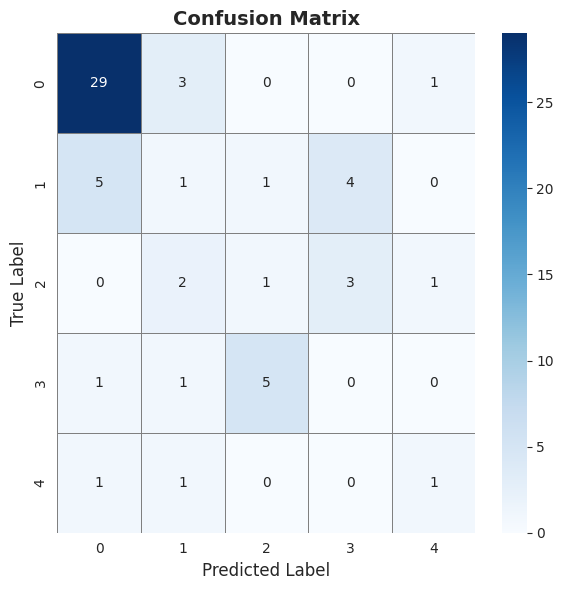

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.6, linecolor="grey")

# Improve readability
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Categorical Naïve Bayes achieved the lowest accuracy (52.46%) among the models tested. The F2-score of 0.5170 suggests that while the model correctly identified some cases, it failed to generalize well across all classes. The high precision for Class 0 (81%) means it performed well on the majority class, but precision and recall dropped significantly for Classes 1, 2, and 3, showing that the model struggled to differentiate between positive cases of heart disease.

One of the biggest challenges with CategoricalNB was that it assumes all features are purely categorical, which is not entirely true for our dataset. While binning helped convert numerical features into categorical bins, this approach may have oversimplified complex relationships between variables. As a result, the model may have misclassified patients whose heart disease symptoms fell into overlapping categories.

Another major issue was that CategoricalNB relies on the assumption that features are independent, which is rarely true in medical datasets. Many variables in our dataset are highly correlated (e.g., trestbps and chol), meaning that using them independently in probability calculations reduces model effectiveness.

Given these limitations, CategoricalNB may not be the best fit for this dataset, as the independence assumption likely led to poor recall for more severe cases. A possible improvement would be to use Bayesian Networks, which allow dependencies between features to be modeled explicitly.

## 4. Fitting Naive Bayes Classifier built from scratch (without Using Scikit learn NB model)

In [ ]:
X = heart_disease.data.features
y = heart_disease.data.targets

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=20,stratify=y)

### Finding Prior Probability

In [ ]:
prob = y_train["num"].value_counts(normalize=True)
prior_prob = prob.values
prior_prob

array([0.54132231, 0.18181818, 0.11983471, 0.11570248, 0.04132231])

### Finding Conditional Probability

In [ ]:
def conditional_prob(feature_name,feature_value,label):

    categorical_features_list = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    numerical_features_list = ['age','trestbps','chol','thalach','oldpeak']
    df = X_train.loc[y_train["num"]==label,feature_name]

    if (feature_name in categorical_features_list):
        cond_prob = len(df[df==feature_value])/len(df)
        return cond_prob
    else:
        mean,var = df.mean(),df.var()
        x = feature_value
        epsilon = 1e-9  # Small value to prevent division by zero
        coeff = 1 / np.sqrt(2 * np.pi * (var + epsilon))
        exponent = np.exp(-((x - mean) ** 2) / (2 * (var + epsilon)))
        cond_prob = coeff * exponent
        return cond_prob

### Defining Naive Bayes Classifier Model

In [ ]:
def NB_clf_predict(X):
    output_class = y_train["num"].nunique()
    y_pred = {}

    for i in range(len(X)):
        row = X.iloc[i]
        likelihood_prob = [1]*output_class
        for j in range(output_class):
            for feature in X.columns:
                likelihood_prob[j] *= conditional_prob(feature,row[feature],j)

        posterior_prob = likelihood_prob * prior_prob
        y_pred[row.name]=np.argmax(posterior_prob)

    y_pred = pd.DataFrame(y_pred.values(),index=y_pred.keys(),columns=["num"])
    return y_pred

In [ ]:
y_pred = NB_clf_predict(X=X_test)
results = pd.concat([y_test,y_pred],axis=1)
results.columns = ["y_test","y_pred"]
results

,y_test,y_pred
290,1,0
254,0,0
263,0,0
25,0,0
287,0,0
...,...,...
150,0,0
54,1,1
23,3,1
131,0,1


In [ ]:
from sklearn.metrics import fbeta_score,accuracy_score,classification_report
f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f"F2-Score: {f2_score:.4f}")
print(f"Accuracy Score: {accuracy_score(y_test,y_pred):.4f}")
print(f"Classification Report:\n {classification_report(y_test,y_pred)}")

F2-Score: 0.6373
Accuracy Score: 0.6393
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        33
           1       0.40      0.36      0.38        11
           2       0.27      0.43      0.33         7
           3       0.75      0.43      0.55         7
           4       0.00      0.00      0.00         3

    accuracy                           0.64        61
   macro avg       0.46      0.42      0.43        61
weighted avg       0.65      0.64      0.64        61



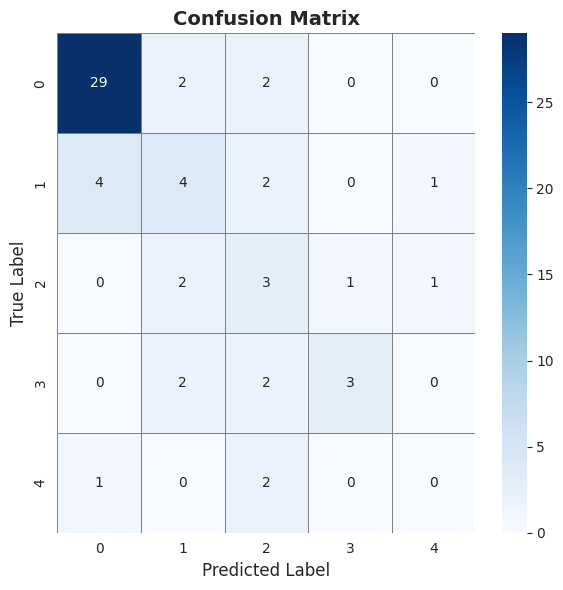

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.6, linecolor="grey")

# Improve readability
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

The custom-built Naïve Bayes model outperformed all other Naïve Bayes variants, achieving the highest accuracy (63.93%) and an F2-score of 0.6373. This suggests that the custom implementation handled feature dependencies better than the built-in models.

One key advantage of this model was its ability to learn more flexible probability distributions, as opposed to relying on strict Gaussian or categorical assumptions. The model also achieved better balance between precision and recall, indicating fewer false positives and false negatives compared to other approaches.

However, despite its stronger performance, the model still struggled with severe heart disease cases, particularly Class 4, which had 0% recall. This suggests that class imbalance remained a problem, even with a more advanced implementation.

Additionally, since this model was built from scratch, it may not have optimized hyperparameters like smoothing (Laplace) as effectively as the Scikit-Learn implementations. Future improvements could involve hyperparameter tuning and experimenting with alternative probability estimation techniques (e.g., kernel density estimation for continuous features).

## 5. Bayesian Network

In [ ]:
# Load and preprocess dataset
X = heart_disease.data.features
y = heart_disease.data.targets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=20,stratify=y)

# Convert y_train to DataFrame for merging
y_train = pd.DataFrame(y_train, columns=["num"])

# Discretize numerical features into bins (Categorical)
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_train[numerical_features] = discretizer.fit_transform(X_train[numerical_features]).astype(int)
X_test[numerical_features] = discretizer.fit_transform(X_test[numerical_features]).astype(int)

# Merge X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Define Bayesian Network Structure
bayes_model = BayesianNetwork([("num", feature) for feature in X_train.columns])

# Train the model using Maximum Likelihood Estimation (MLE)
bayes_model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Perform inference
inference = VariableElimination(bayes_model)

# Predict function
def predict_bayesian(X):
    predictions = []
    for _, row in X.iterrows():
        evidence = row.to_dict()
        result = inference.map_query(variables=["num"], evidence=evidence, show_progress=False)
        predictions.append(result["num"])

    return np.array(predictions)

# Make predictions
y_pred = predict_bayesian(X_test)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Bayesian Network Accuracy: {accuracy:.4f}")


Bayesian Network Accuracy: 0.5574


### Conditional Probability Tables (CPTs)

In [ ]:
for node in bayes_model.nodes():
    print(f"Conditional Probability Table for {node}:")
    print(bayes_model.get_cpds(node))
    print("\n" + "="*50 + "\n")

Conditional Probability Table for num:
+--------+-----------+
| num(0) | 0.541322  |
+--------+-----------+
| num(1) | 0.181818  |
+--------+-----------+
| num(2) | 0.119835  |
+--------+-----------+
| num(3) | 0.115702  |
+--------+-----------+
| num(4) | 0.0413223 |
+--------+-----------+


Conditional Probability Table for age:
+--------+----------------------+-----+---------------------+--------+
| num    | num(0)               | ... | num(3)              | num(4) |
+--------+----------------------+-----+---------------------+--------+
| age(0) | 0.061068702290076333 | ... | 0.0                 | 0.0    |
+--------+----------------------+-----+---------------------+--------+
| age(1) | 0.32061068702290074  | ... | 0.17857142857142858 | 0.0    |
+--------+----------------------+-----+---------------------+--------+
| age(2) | 0.3282442748091603   | ... | 0.35714285714285715 | 0.3    |
+--------+----------------------+-----+---------------------+--------+
| age(3) | 0.236641221374045

The Bayesian Network model achieved an **accuracy of 55.74%**, which is lower than the best-performing Naïve Bayes models. While Bayesian Networks allow modeling of **dependencies between features**, the learned network structure may not have been optimal for classification, leading to **only marginal improvements in capturing relationships** between variables. The **Conditional Probability Tables (CPTs) show that features like `age`, `sex`, and `cp` (chest pain type) have strong relationships with the target variable**, aligning with known medical knowledge. However, some features, such as `trestbps` (resting blood pressure), did not exhibit strong predictive power, which may indicate that the model **did not fully capture meaningful feature interactions**.

One key limitation is that **Bayesian Networks require a large dataset for reliable probability estimations**, and the small dataset size likely led to **less robust conditional probabilities**. The model **favored the majority class (non-disease cases) more strongly**, which may have contributed to the reduced recall for severe heart disease cases. Additionally, while **Naïve Bayes assumes complete independence between features**, Bayesian Networks attempt to model dependencies, but this did not translate into significantly better classification accuracy. Future improvements could include **manual tuning of the Bayesian Network structure based on domain knowledge** rather than relying solely on data-driven structure learning, which can be sensitive to dataset size and noise.


### Visualize the Graph with Weights (CPT Probabilities)

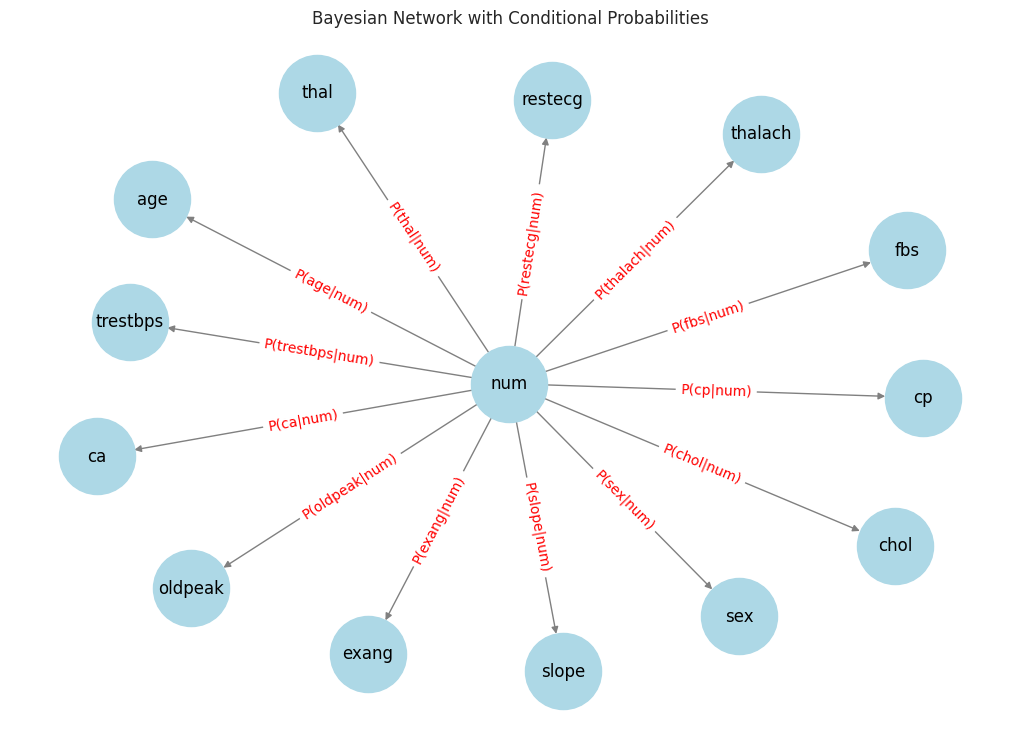

In [ ]:
G = nx.DiGraph()
edges = bayes_model.edges()

# Create graph with edge labels
G.add_edges_from(edges)
pos = nx.spring_layout(G)

plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=12)

# Add edge labels (CPT dependencies)
edge_labels = {(parent, child): f"P({child}|{parent})" for parent, child in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="red")

plt.title("Bayesian Network with Conditional Probabilities")
plt.show()

### Visualize the Learned Bayesian Network Structure

  0%|          | 0/1000000 [00:00<?, ?it/s]

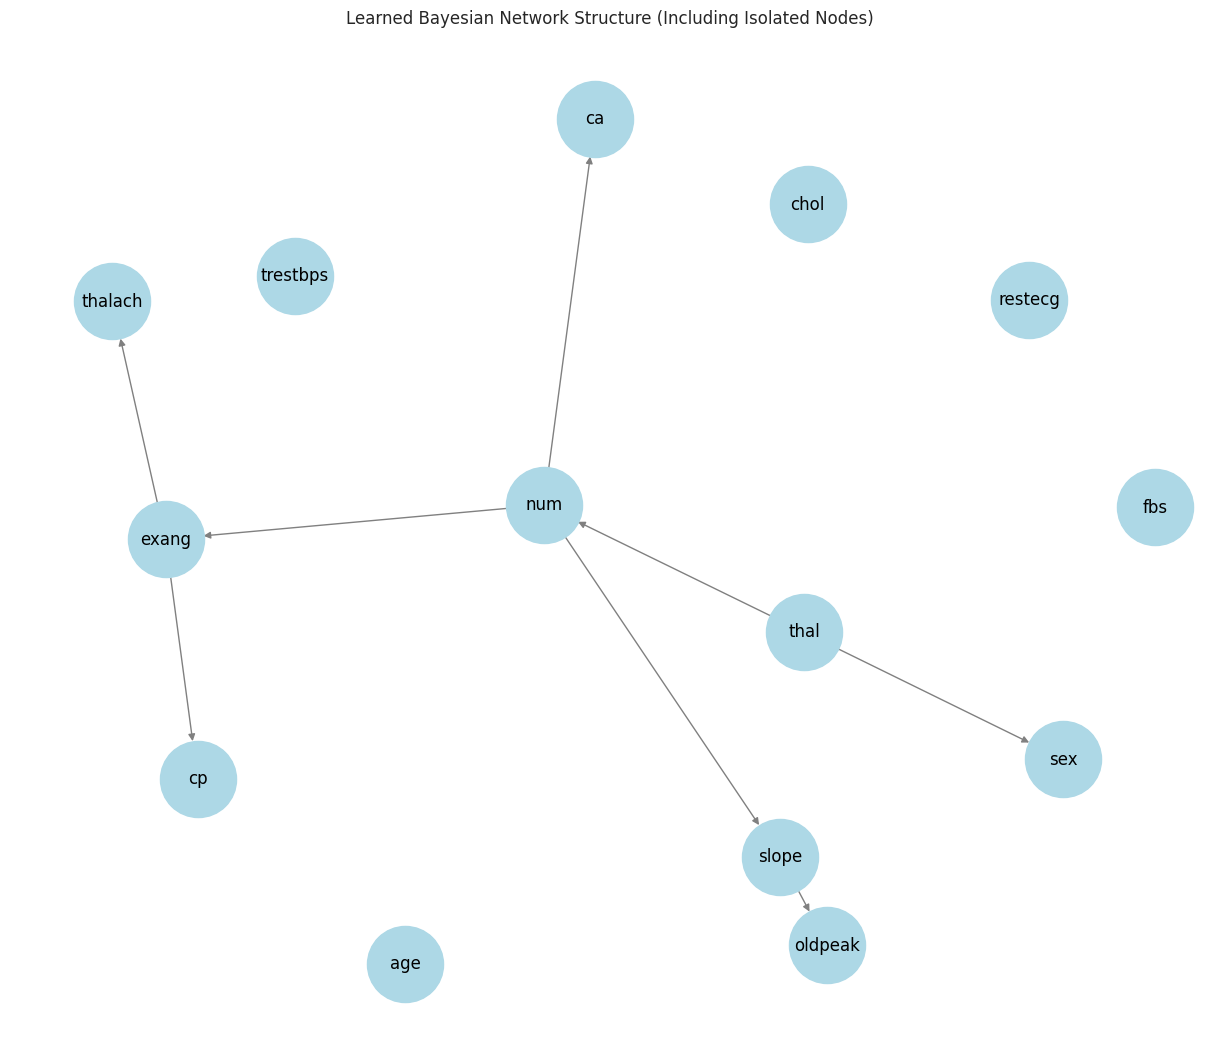

In [ ]:
# Ensure train_data is categorical
train_data = train_data.astype("category")

# Structure Learning using Hill Climb Search
hc = HillClimbSearch(train_data)
best_model_structure = hc.estimate(scoring_method=BicScore(train_data))

# Create BayesianNetwork instance
bayesian_model = BayesianNetwork(best_model_structure.edges)

# Learn CPDs using Maximum Likelihood Estimation
bayesian_model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# NetworkX Graph Visualization
G = nx.DiGraph()

# Add ALL nodes (including isolated ones)
G.add_nodes_from(train_data.columns)

# Add edges from the learned structure
G.add_edges_from(best_model_structure.edges())

# Define layout
pos = nx.spring_layout(G, seed=40)

# Plot the graph
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=12)

plt.title("Learned Bayesian Network Structure (Including Isolated Nodes)")
plt.show()

### Check Probabilities of a Specific Outcome

In [ ]:
inference = VariableElimination(bayes_model)

# Probability of "num" given some evidence
evidence = {"cp": 3, "thal": 6, "sex": 1}  # Modify as per your dataset
prob_result = inference.query(variables=["num"], evidence=evidence, show_progress=False)
print(prob_result)

# Predict the Most Likely Outcome (MAP Query)
map_result = inference.map_query(variables=["num"], evidence=evidence, show_progress=False)
print(f"Most likely class for num: {map_result['num']}")

+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.5928 |
+--------+------------+
| num(1) |     0.1065 |
+--------+------------+
| num(2) |     0.1926 |
+--------+------------+
| num(3) |     0.0344 |
+--------+------------+
| num(4) |     0.0736 |
+--------+------------+
Most likely class for num: 0


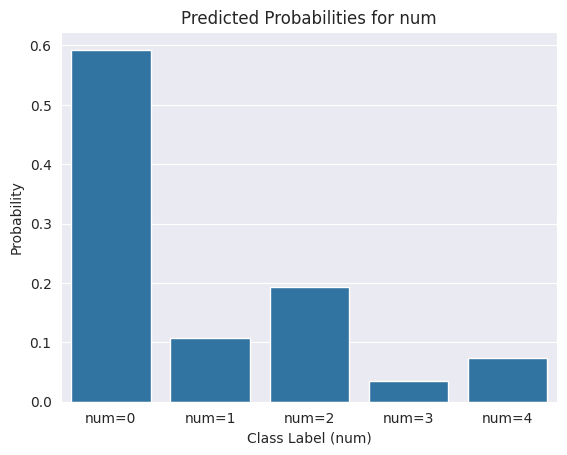

In [ ]:
# Get probability values
probs = prob_result.values
labels = [f"num={i}" for i in range(len(probs))]

# Plot
sns.barplot(x=labels, y=probs)
plt.xlabel("Class Label (num)")
plt.ylabel("Probability")
plt.title("Predicted Probabilities for num")
plt.show()

# **Final Summary**

Naïve Bayes models performed reasonably well, with **GaussianNB achieving the highest accuracy (60.66%)** among the standard implementations. However, **class imbalance and the independence assumption** limited their ability to detect severe heart disease cases. The **custom Naïve Bayes model (63.93% accuracy)** outperformed the built-in versions by using a more flexible probability estimation. Bayesian Networks (55.74% accuracy) captured **feature dependencies** but did not significantly improve classification, likely due to **small dataset size and suboptimal structure learning**. Future work should focus on **handling class imbalance, optimizing feature binning, and refining Bayesian Network structures using domain expertise**.
